In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (175341, 45)
Testing data shape: (82332, 45)


In [4]:
print(train_data.size)
print(test_data.size)

7890345
3704940


In [5]:
print("\nColumns in dataset:")
print(train_data.columns.tolist())

# Check data types
print("\nData types:")
print(train_data.dtypes)

# Check label distribution
print("\nTraining label distribution:")
print(train_data['label'].value_counts())
print(train_data['label'].value_counts(normalize=True))

print("\nTest label distribution:")
print(test_data['label'].value_counts())
print(test_data['label'].value_counts(normalize=True))

# Check attack categories if available
if 'attack_cat' in train_data.columns:
    print("\nAttack categories in training data:")
    print(train_data['attack_cat'].value_counts())
    
    print("\nAttack categories in test data:")
    print(test_data['attack_cat'].value_counts())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())

# Get basic statistics for numerical features
print("\nSummary statistics for numerical features (sample):")
print(train_data.describe().iloc[:, :5])  # First 5 columns only for brevity



Columns in dataset:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']

Data types:
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss         

In [6]:
X_train = train_data.drop(['id', 'attack_cat', 'label'], axis=1)
y_train = train_data['label']  # For binary classification
y_train_multi = train_data['attack_cat']  # For multi-class classification

X_test = test_data.drop(['id', 'attack_cat', 'label'], axis=1)
y_test = test_data['label']
y_test_multi = test_data['attack_cat']

In [7]:
categorical_cols = ['proto', 'service', 'state']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)

# Ensure train and test have the same columns
train_cols = set(X_train_encoded.columns)
test_cols = set(X_test_encoded.columns)

# Add missing columns to test set
for col in train_cols - test_cols:
    X_test_encoded[col] = 0

# Add missing columns to train set
for col in test_cols - train_cols:
    X_train_encoded[col] = 0

X_test_encoded = X_test_encoded[X_train_encoded.columns]

# 3. Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Binary classification model
print("Training binary classification model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    # Handle class imbalance
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)

xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

Training binary classification model...


In [9]:
print("\nBinary Classification Results:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Binary Classification Results:
[[31717  5283]
 [ 1620 43712]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     37000
           1       0.89      0.96      0.93     45332

    accuracy                           0.92     82332
   macro avg       0.92      0.91      0.91     82332
weighted avg       0.92      0.92      0.92     82332



Attack category mapping:
Analysis: 0
Backdoor: 1
DoS: 2
Exploits: 3
Fuzzers: 4
Generic: 5
Normal: 6
Reconnaissance: 7
Shellcode: 8
Worms: 9

Training multi-class model...

Multi-class Classification Results:
                precision    recall  f1-score   support

      Analysis       0.03      0.03      0.03       677
      Backdoor       0.06      0.13      0.08       583
           DoS       0.51      0.07      0.13      4089
      Exploits       0.58      0.89      0.70     11132
       Fuzzers       0.31      0.57      0.40      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.96      0.76      0.85     37000
Reconnaissance       0.93      0.81      0.86      3496
     Shellcode       0.34      0.72      0.46       378
         Worms       0.69      0.57      0.62        44

      accuracy                           0.77     82332
     macro avg       0.54      0.55      0.51     82332
  weighted avg       0.83      0.77      0.78     82332



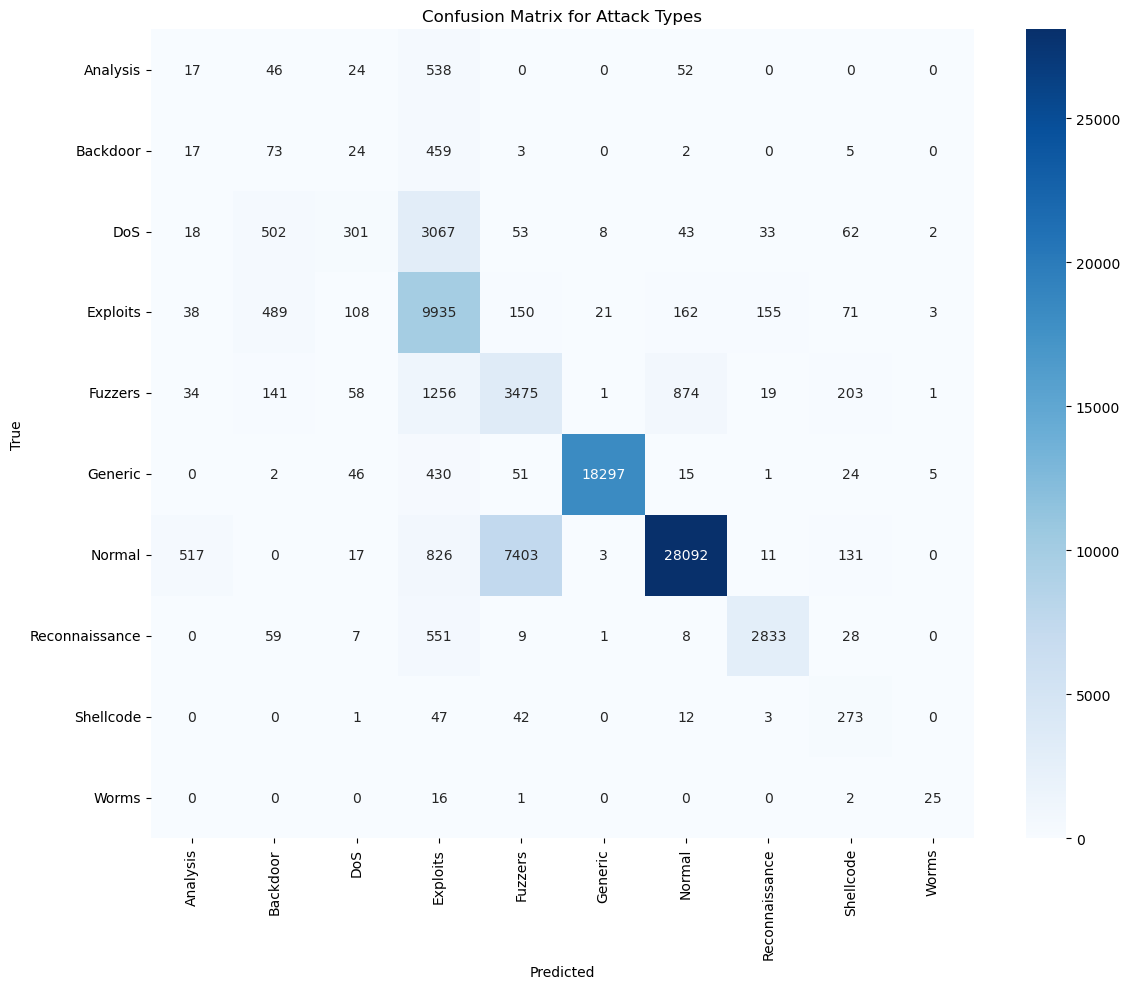

In [10]:
# Encode attack categories
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Create label encoder
le = LabelEncoder()
# Fit and transform training data
y_train_multi_encoded = le.fit_transform(y_train_multi)
# Transform test data
y_test_multi_encoded = le.transform(y_test_multi)

# Store mapping for reference
attack_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Attack category mapping:")
for category, code in attack_label_mapping.items():
    print(f"{category}: {code}")

# Train multi-class XGBoost with encoded labels
print("\nTraining multi-class model...")
xgb_multi = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_multi.fit(X_train_scaled, y_train_multi_encoded)

# Predict
y_pred_multi_encoded = xgb_multi.predict(X_test_scaled)

# Convert predictions back to original categories for reporting
y_pred_multi = le.inverse_transform(y_pred_multi_encoded)

# Evaluate
print("\nMulti-class Classification Results:")
print(classification_report(y_test_multi, y_pred_multi))

# Create a confusion matrix with proper labels
cm = confusion_matrix(y_test_multi_encoded, y_pred_multi_encoded)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Attack Types')
plt.tight_layout()
plt.savefig('attack_types_confusion_matrix.png')

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]
}

# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # number of parameter settings sampled
    scoring='f1',  # or 'accuracy', 'roc_auc'
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

# Get best parameters
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train final model with best parameters
best_model = xgb.XGBClassifier(**random_search.best_params_, random_state=42)
best_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 0.469243596081816, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best score: 0.9349685562018081


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Get feature importance
importance = best_model.feature_importances_
indices = np.argsort(importance)[::-1]

# Print top 20 features
print("Top 20 features:")
feature_names = X_train_encoded.columns
for i in range(20):
    print(f"{feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

# Select top k features
k = 50  # adjust based on feature importance analysis
top_indices = indices[:k]
X_train_selected = X_train_scaled[:, top_indices]
X_test_selected = X_test_scaled[:, top_indices]

# Train model with selected features
selected_model = xgb.XGBClassifier(**random_search.best_params_, random_state=42)
selected_model.fit(X_train_selected, y_train)

Top 20 features:
sttl: 0.7159
swin: 0.0316
ct_srv_dst: 0.0302
ct_dst_sport_ltm: 0.0198
sbytes: 0.0149
smean: 0.0138
proto_unas: 0.0120
proto_udp: 0.0111
ct_state_ttl: 0.0092
dpkts: 0.0091
service_http: 0.0084
sloss: 0.0074
ct_dst_src_ltm: 0.0071
dbytes: 0.0068
dmean: 0.0067
dttl: 0.0062
synack: 0.0059
trans_depth: 0.0056
service_-: 0.0048
service_dns: 0.0048


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Train different models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
cb_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

rf_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)
cb_model.fit(X_train_scaled, y_train)

# Create voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_model),
        ('rf', rf_model),
        ('lgbm', lgbm_model),
        ('catboost', cb_model)
    ],
    voting='soft'  # Use predicted probabilities
)

voting_clf.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6359
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680622 -> initscore=0.756633
[LightGBM] [Info] Start training from score 0.756633
[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6359
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 186
[LightGBM] [In

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.2,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lgbm', LGBMClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x000002105767E150>)],
                 voting='soft')

In [14]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Try SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Or SMOTETomek (combines over and under sampling)
smote_tomek = SMOTETomek(random_state=42)
X_train_stmk, y_train_stmk = smote_tomek.fit_resample(X_train_scaled, y_train)

# Train on resampled data
balanced_model = xgb.XGBClassifier(**random_search.best_params_, random_state=42)
balanced_model.fit(X_train_stmk, y_train_stmk)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=cv, scoring='f1')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Cross-validation scores: [0.96400127 0.96391479 0.96558601 0.96630072 0.9636383 ]
Mean CV score: 0.9647 (±0.0011)


In [16]:
class_weights = {
    0: 1.0,  # Analysis
    1: 2.0,  # Backdoor 
    2: 3.0,  # DoS - performed poorly, so higher weight
    3: 1.0,  # Exploits
    4: 1.0,  # Fuzzers
    5: 0.5,  # Generic - performed well, so lower weight
    6: 0.5,  # Normal - performed well
    7: 0.5,  # Reconnaissance
    8: 1.0,  # Shellcode
    9: 2.0   # Worms
}

# Create sample weights based on class weights
sample_weights = np.ones(len(y_train_multi_encoded))
for idx, label in enumerate(y_train_multi_encoded):
    sample_weights[idx] = class_weights[label]

# Train model with sample weights
weighted_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
weighted_model.fit(X_train_scaled, y_train_multi_encoded, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Function to evaluate and compare models
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # For probability-based metrics
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        try:
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = None
    else:
        auc = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Display results
    print(f"===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    if auc is not None:
        print(f"ROC AUC: {auc:.4f}")
    
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Return the metrics for comparison
    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "auc": auc,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1-score": report['weighted avg']['f1-score']
    }

# Create a list to store results for comparison
results = []

# Evaluate the baseline model
baseline_results = evaluate_model(best_model, X_test_scaled, y_test, "Baseline XGBoost")
results.append(baseline_results)

# Evaluate feature selection model
selected_results = evaluate_model(selected_model, X_test_selected, y_test, "Feature Selected XGBoost")
results.append(selected_results)

# Evaluate SMOTE balanced model
smote_results = evaluate_model(balanced_model, X_test_scaled, y_test, "SMOTE-Balanced XGBoost")
results.append(smote_results)

# Evaluate ensemble model
ensemble_results = evaluate_model(voting_clf, X_test_scaled, y_test, "Voting Ensemble")
results.append(ensemble_results)


===== Baseline XGBoost Evaluation =====
Accuracy: 0.9057
ROC AUC: 0.9839

Confusion Matrix:
[[30845  6155]
 [ 1606 43726]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     37000
           1       0.88      0.96      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.91      0.90      0.90     82332
weighted avg       0.91      0.91      0.90     82332

===== Feature Selected XGBoost Evaluation =====
Accuracy: 0.9060
ROC AUC: 0.9840

Confusion Matrix:
[[30908  6092]
 [ 1645 43687]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     37000
           1       0.88      0.96      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.91      0.90      0.90     82332
weighted avg       0.91      0.91      0.91     82332

===== SMOTE-Balanced XGBoost Evaluation ====

In [18]:
def evaluate_multiclass(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"===== {model_name} Class-wise Performance =====")
    
    # Create a dictionary of class names to class IDs if needed
    class_mapping = {v: k for k, v in attack_label_mapping.items()}
    
    for class_id, metrics in report.items():
        if class_id not in ['accuracy', 'macro avg', 'weighted avg']:
            class_name = class_mapping.get(int(class_id), class_id)
            print(f"Class: {class_name}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-score: {metrics['f1-score']:.4f}")
            print(f"  Support: {metrics['support']}")
            print()

# For multi-class models
evaluate_multiclass(weighted_model, X_test_scaled, y_test_multi_encoded, "Weighted Multi-class XGBoost")

# Compare results in a tabular format
import pandas as pd

results_df = pd.DataFrame(results)
print("\n===== Model Comparison =====")
print(results_df.set_index('model_name'))


===== Weighted Multi-class XGBoost Class-wise Performance =====
Class: Analysis
  Precision: 0.0055
  Recall: 0.0059
  F1-score: 0.0057
  Support: 677.0

Class: Backdoor
  Precision: 0.0419
  Recall: 0.0892
  F1-score: 0.0570
  Support: 583.0

Class: DoS
  Precision: 0.3349
  Recall: 0.6628
  F1-score: 0.4450
  Support: 4089.0

Class: Exploits
  Precision: 0.7061
  Recall: 0.6767
  F1-score: 0.6911
  Support: 11132.0

Class: Fuzzers
  Precision: 0.2566
  Recall: 0.6762
  F1-score: 0.3720
  Support: 6062.0

Class: Generic
  Precision: 0.9988
  Recall: 0.9675
  F1-score: 0.9829
  Support: 18871.0

Class: Normal
  Precision: 0.9926
  Recall: 0.6344
  F1-score: 0.7741
  Support: 37000.0

Class: Reconnaissance
  Precision: 0.9669
  Recall: 0.7760
  F1-score: 0.8610
  Support: 3496.0

Class: Shellcode
  Precision: 0.3118
  Recall: 0.7011
  F1-score: 0.4316
  Support: 378.0

Class: Worms
  Precision: 0.6200
  Recall: 0.7045
  F1-score: 0.6596
  Support: 44.0


===== Model Comparison =====
   

In [19]:
import pandas as pd
import re
import json
from datetime import datetime

def parse_hdfs_logs(log_file):
    # Common regex patterns for HDFS logs
    pattern = r'(\d+\.\d+\.\d+\.\d+) (\S+) (\S+): (\d+) (\S+) (.*)'
    
    logs = []
    with open(log_file, 'r') as f:
        for line in f:
            match = re.match(pattern, line.strip())
            if match:
                ip, date, level, block_id, msg_type, content = match.groups()
                logs.append({
                    'timestamp': date,
                    'level': level,
                    'block_id': block_id,
                    'msg_type': msg_type,
                    'content': content,
                    'source': ip
                })
    
    return pd.DataFrame(logs)

# Similarly define parsers for other log types
def parse_linux_logs(log_file):
    # Linux syslog pattern
    pattern = r'(\w+ \d+ \d+:\d+:\d+) (\S+) (\S+)\[(\d+)\]: (.*)'
    # Parsing implementation...

def parse_openssh_logs(log_file):
    # SSH log pattern
    pattern = r'(\w+ \d+ \d+:\d+:\d+) (\S+) sshd\[(\d+)\]: (.*)'
    # Parsing implementation...

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class LogKeyDataset(Dataset):
    def __init__(self, log_keys, window_size):
        self.log_keys = log_keys
        self.window_size = window_size
        
    def __len__(self):
        return len(self.log_keys) - self.window_size
        
    def __getitem__(self, idx):
        x = self.log_keys[idx:idx+self.window_size]
        y = self.log_keys[idx+self.window_size]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

class DeepLog(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(DeepLog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def detect_anomalies(self, x, y, top_k=9):
        """Return True if prediction not in top k predictions"""
        with torch.no_grad():
            output = self(x)
            _, predicted = torch.topk(output, top_k)
            return y.item() not in predicted[0].tolist()

In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def time_based_anomaly_detection(df, time_window='1H'):
    # Group logs by time window and extract features
    df_grouped = df.set_index('datetime').groupby(pd.Grouper(freq=time_window))
    
    features = []
    for name, group in df_grouped:
        if len(group) > 0:
            # Feature calculation per time window
            feature_vector = {
                'log_count': len(group),
                'error_count': len(group[group['level'] == 'ERROR']),
                'warning_count': len(group[group['level'] == 'WARN']),
                'unique_sources': group['source'].nunique(),
                'max_time_delta': group['time_delta'].max(),
                'avg_time_delta': group['time_delta'].mean(),
                # Add message type counts
                **{f'count_{col}': sum(group[col]) for col in group.columns if col.startswith('msg_')}
            }
            features.append(feature_vector)
    
    # Convert to DataFrame
    feature_df = pd.DataFrame(features)
    
    # Scale features
    scaler = StandardScaler()
    feature_scaled = scaler.fit_transform(feature_df)
    
    # Train isolation forest
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(feature_scaled)
    
    # Get anomaly scores (-1 for anomalies, 1 for normal)
    anomaly_scores = model.predict(feature_scaled)
    
    return anomaly_scores, feature_df

In [23]:
def align_log_network_data(log_anomalies, network_data, time_window='1H'):
    """
    Aligns log anomaly detection results with network traffic data based on time windows
    """
    # Ensure both datasets have compatible datetime indices
    log_anomalies = log_anomalies.set_index('datetime')
    network_data = network_data.set_index('datetime')
    
    # Resample both to the same time intervals
    log_resampled = log_anomalies.resample(time_window).sum()
    network_resampled = network_data.resample(time_window).mean()
    
    # Join the datasets on time index
    combined = pd.concat([log_resampled, network_resampled], axis=1)
    
    return combined

In [24]:
def align_log_network_data(log_anomalies, network_data, time_window='1H'):
    """
    Aligns log anomaly detection results with network traffic data based on time windows
    """
    # Ensure both datasets have compatible datetime indices
    log_anomalies = log_anomalies.set_index('datetime')
    network_data = network_data.set_index('datetime')
    
    # Resample both to the same time intervals
    log_resampled = log_anomalies.resample(time_window).sum()
    network_resampled = network_data.resample(time_window).mean()
    
    # Join the datasets on time index
    combined = pd.concat([log_resampled, network_resampled], axis=1)
    
    return combined

In [25]:
def create_multimodal_features(log_features, network_features):
    """
    Combines features from log analysis and network traffic analysis
    """
    # 1. Direct concatenation of features
    combined_features = pd.concat([log_features, network_features], axis=1)
    
    # 2. Create interaction features
    # Example: Multiply log anomaly score with network traffic volume
    if 'anomaly_score' in log_features.columns and 'traffic_volume' in network_features.columns:
        combined_features['anomaly_traffic_interaction'] = (
            log_features['anomaly_score'] * network_features['traffic_volume']
        )
    
    # 3. Create temporal correlation features
    # Example: Rate of change in both log events and network events
    combined_features['log_network_correlation'] = (
        combined_features['log_event_count'].pct_change() * 
        combined_features['network_event_count'].pct_change()
    )
    
    return combined_features

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def train_multimodal_model(combined_features, labels):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, labels, test_size=0.3, random_state=42
    )
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    accuracy = model.score(X_test, y_test)
    print(f"Multi-modal model accuracy: {accuracy:.4f}")
    
    return model

def detect_attacks_multimodal(model, log_data, network_data):
    """
    End-to-end function for multi-modal attack detection
    """
    # 1. Process logs
    log_features = extract_log_features(log_data)
    log_anomalies, _ = time_based_anomaly_detection(log_features)
    
    # 2. Extract network features (assuming this is already done)
    
    # 3. Align and combine features
    combined_features = create_multimodal_features(log_features, network_data)
    
    # 4. Make predictions
    predictions = model.predict(combined_features)
    probabilities = model.predict_proba(combined_features)
    
    # 5. Return results with explanations
    results = {
        'predictions': predictions,
        'probabilities': probabilities,
        'log_anomalies': log_anomalies,
        'high_risk_features': get_feature_importance(model, combined_features)
    }
    
    return results